In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set("talk", style="ticks", palette="husl", color_codes=True)

from astropy.io import fits

from tqdm import tqdm

import contextlib
import sys

import warnings
warnings.filterwarnings("ignore")

from pyFIT3D.common.tools import get_wave_from_header


class DummyFile(object):
    def write(self, x): pass

@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = DummyFile()
    yield
    sys.stdout = save_stdout

In [2]:
experiment = "ic342"
inp_path = "../../_fitting-data/IC342/"
obs_path = f'_data/{experiment}/obs/'
out_path = f'_data/{experiment}/out/'
fig_path = f"_data/{experiment}/figs"
os.makedirs(obs_path, exist_ok=True)
os.makedirs(out_path, exist_ok=True)
os.makedirs(fig_path, exist_ok=True)

ori_rss = sorted([os.path.join(root,file) for root, subs, files in os.walk(inp_path) for file in files if file.startswith("CS.") and file.endswith(".RSS.fits.gz")])
err_rss = [os.path.join(os.path.dirname(file), f"e_{os.path.basename(file)}") for file in ori_rss]

In [3]:
# using the initial values:
#
# Instrumental dispersion: 2.5 AA
sigma_inst = 0.001

# Velocity dispersion of the gas in AA
sigma_gas = 3.7

# Masks:
#     File with list of ranges of wavelength to be masked in whole analysis
mask_list = None#'../../_fitting-data/_configs/mask_elines.txt'

######################
######################
# Non linear analysis: (redshift, observed dispersion and dust attenuation)
#     wavelength range: 
#         [3850, 4700] AA for the redshift and sigma analysis
#         [3800, 7000] AA for the dust attenuation
w_min_max = [3800, 9500]
nl_w_min_max = [4700, 6000]

#     models:
#         Miles solar 3 models
ssp_nl_fit_file = '../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-5.fits.gz'

#     emission lines to be masked:
elines_mask_file = '../../_fitting-data/_configs/MaNGA/emission_lines_long_list.txt'

#     redshift:
#         initial value: 0.02449
#                 delta: 0.0001
#                   min: 0.02349
#                   max: 0.02549
redshift_set = [0.0001, 0, -0.5, 0.5]

#     dispersion: (km/s)
#         initial value: 30
#                 delta: 20
#                   min: 1
#                   max: 150
sigma_set = [0, 0, 0, 350]

#     dust attenuation at V band (mag):
#         initial value: 0.3
#                 delta: 0.15
#                   min: 0
#                   max: 1.6
AV_set = [0, 0.1, 0, 2.5]

ssp_file = '../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-100.fits.gz'
par_file = '../../_fitting-data/_basis_mastar_v2/stellar-basis-params-100.fits.gz'

# plot options
stellar_param = fits.open(par_file, memmap=False)

labels = {"TEFF":r"$\log{T_\text{eff}}$", "LOGG":r"$\log{g}$", "MET":r"$[\text{Fe}/\text{H}]$", "ALPHAM":r"$[\alpha/\text{Fe}]$"}
cmap = "binary_r"
color = sns.color_palette(cmap)[0]

In [4]:
# import subprocess


# subprocess.run(["tsp", "-S", "30"])
# for sed_file, err_file in tqdm(zip(ori_rss, err_rss), total=len(ori_rss), desc="fitting IC342", ascii=True, unit="SED"):
#     label = os.path.basename(sed_file).replace(".RSS.fits.gz","").replace("CS.","")
#     if os.path.isfile(os.path.join(out_path,f"output.{label}.fits.gz")): continue
#     subprocess.run(f"tsp lvm-dap {sed_file} {ssp_file} {sigma_inst} {label} --input-fmt rss --error-file {err_file} --rsp-nl-file {ssp_nl_fit_file} --w-range {' '.join(map(str,w_min_max))} --w-range-nl {' '.join(map(str,nl_w_min_max))} --redshift {' '.join(map(str,redshift_set))} --sigma {' '.join(map(str,sigma_set))} --AV {' '.join(map(str,AV_set))} --sigma-gas {sigma_gas} --emission-lines-file {elines_mask_file} -cd --single-gas-fit --output-path {out_path}".split(), capture_output=True)

In [5]:
# from lvmdap.analysis.plotting import plot_dap_fit


# for sed_file in tqdm(ori_rss, desc="plotting results", ascii=True, unit="SED"):
#     label = os.path.basename(sed_file).replace(".RSS.fits.gz","").replace("CS.","")
    
#     model = pd.read_csv(os.path.join(out_path,f"coeffs_{label}"), sep="\s+")
#     model.columns = model.columns[1:].tolist()+["#"]
#     model.drop(columns="#", inplace=True)

#     f = fits.open(os.path.join(out_path,f"output.{label}.fits.gz"), memmap=False)

#     for j in range(f[0].data.shape[1]):
#         fig_file = os.path.join(fig_path, f"{label}_{j:03d}.png")
#         if os.path.isfile(fig_file): continue

#         fig, ax0, axs = plot_dap_fit(
#             f[0],
#             model.COEFF.values,
#             stellar_param,
#             labels, cmap, color, rss_voxel=j
#         )
#         fig.savefig(fig_file, bbox_inches="tight")
#         plt.close(fig)
#         f.close()
#     del f

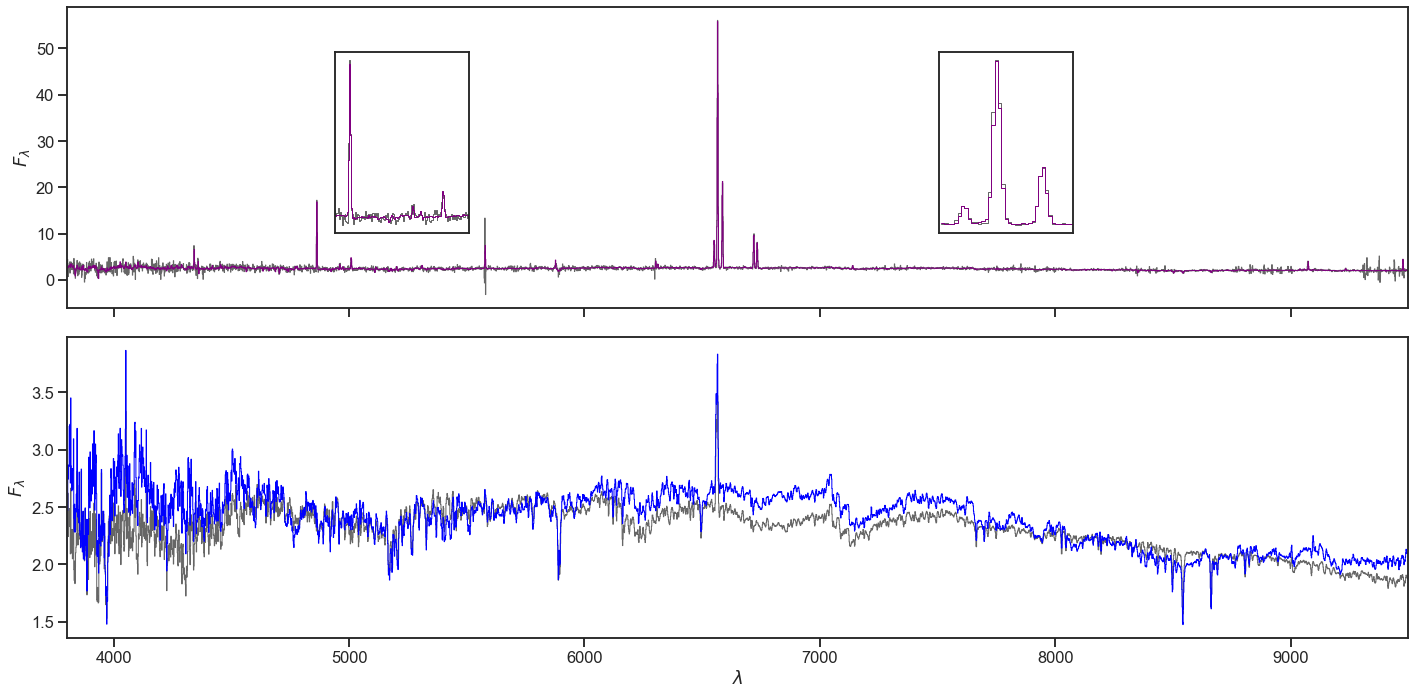

In [9]:
label = "manga-9673-9101"
# label = "manga-10146-12704"
i = 14

models = fits.open(f"{out_path}/output.{label}.fits.gz")
models[0].header
wl = get_wave_from_header(models[0].header)
fl_o = models[0].data[0,i,:]
fl_m = models[0].data[1,i,:]
fl_j = models[0].data[2,i,:]
fl_g = models[0].data[3,i,:]
fl_r = models[0].data[4,i,:]
fl_n = models[0].data[5,i,:]

fig, (ax1,ax2) = plt.subplots(2, figsize=(20,10), sharex=True, sharey=False)
plt.xlim(*w_min_max)

mask_a1 = (w_min_max[0]<=wl)&(wl<=w_min_max[1])
ax1.step(wl[mask_a1], fl_o[mask_a1], "-", color="0.4", lw=1)
ax1.step(wl[mask_a1], fl_j[mask_a1], "-", color="purple", lw=1)
# ax1.set_ylim(0,4)
ax1.set_ylabel(r"$F_\lambda$")
_, ymax = ax1.get_ylim()
# for ewl in elines_r:
#     if w_min_max[0]<=ewl<=w_min_max[1]:
#         ax1.axvline(ewl, ls="--", lw=1, color="0.2")
#         ax2.axvline(ewl, ls="--", lw=1, color="0.2", zorder=999)
#         if ewl in [5006.84, 6583.6, 6730.85]:
#             ax1.text(ewl+17, ymax-ymax*0.05, elines_r[ewl], ha="left", va="top", fontsize="small", rotation=90, color="0.2")
#         else:
#             ax1.text(ewl-8, ymax-ymax*0.05, elines_r[ewl], ha="right", va="top", fontsize="small", rotation=90, color="0.2")

axins1 = ax1.inset_axes([0.20, 0.25, 0.1, 0.6])
axins1.set_xlim(4840,5050)
mask_ai1 = (4840<=wl)&(wl<=5050)
axins1.step(wl[mask_ai1], fl_o[mask_ai1], "-", color="0.4", lw=1)
axins1.step(wl[mask_ai1], fl_j[mask_ai1], "-", color="purple", lw=1)
# axins1.set_ylim(0,5)
axins1.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
# ax1.indicate_inset_zoom(axins1)

axins2 = ax1.inset_axes([0.65, 0.25, 0.1, 0.6])
# axins2.set_xlim(6700,6750)
# mask_ai2 = (6700<=wl)&(wl<=6750)
axins2.set_xlim(6540,6600)
mask_ai2 = (6540<=wl)&(wl<=6600)
axins2.step(wl[mask_ai2], fl_o[mask_ai2], "-", color="0.4", lw=1)
axins2.step(wl[mask_ai2], fl_j[mask_ai2], "-", color="purple", lw=1)
# axins2.set_ylim(0,1.5)
axins2.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
# ax1.indicate_inset_zoom(axins2)

# ax2_ylims = ax2.get_ylim()
ax2.step(wl[mask_a1], (fl_o-fl_g)[mask_a1], "-", color="0.4", lw=1)
ax2.step(wl[mask_a1], (fl_m)[mask_a1], "-", color="blue", lw=1)
# ax2.set_ylim(ax2_ylims)
ax2.set_xlabel(r"$\lambda$")
ax2.set_ylabel(r"$F_\lambda$")

fig.tight_layout()

In [7]:
# from pyFIT3D.common.gas_tools import detect_create_ConfigEmissionModel


# wl_mask = (w_min_max[0]<=wl)&(wl<=w_min_max[1])
# config_filenames, wl_chunks, wave_peaks_tot, wave_peaks_tot_rf = detect_create_ConfigEmissionModel(
#     wl[wl_mask], (fl_o-fl_m)[wl_mask],
#     redshift=redshift_set[0],
#     sigma_guess=sigma_gas,
#     chunks=4,
#     polynomial_order=1,
#     polynomial_coeff_guess=[0.000, 0.001],
#     polynomial_coeff_boundaries=[[-1e13, 1e13], [-1e13, 1e13]],
#     flux_boundaries_fact=[0.001, 1000],
#     sigma_boundaries_fact=[0.1, 1.5],
#     v0_boundaries_add=[-50, 50],
#     peak_find_nsearch=1,
#     peak_find_threshold=0.5,
#     peak_find_dmin=1,
#     crossmatch_list_filename=elines_mask_file,
#     crossmatch_absdmax_AA=5,
#     crossmatch_redshift_search_boundaries=[redshift_set[1]-0.001, redshift_set[1]+0.001],
# #     crossmatch_redshift_search_step=redshift_set[1],
#     sort_by_flux=True,
#     output_path=".",
#     verbose=1,
#     plot=1,
# )

# wave_peaks_tot, wave_peaks_tot_rf